In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
os.chdir(r"C:\Users\kelvi\Documents\Berkeley\Term 2\Projects")
df = pd.read_excel(r"Regimes\Data\Asia\state_z_asia.xlsx")
sectors = pd.read_excel(r"Regimes\Data\Sectors\Per Region\Sector Asia.xlsx")


In [4]:
def _to_period_m_from_col(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """Ensure df[col] exists and is Period[M]; return df with PeriodIndex('M')."""
    if col not in df.columns:
        raise ValueError(f"Expected column '{col}' not found.")
    s = df[col]
    if isinstance(getattr(s, "dtype", None), pd.PeriodDtype):
        per = s.astype("period[M]")
    else:
        per = pd.to_datetime(s, errors="coerce").dt.to_period("M")
    out = df.copy()
    out = out.assign(**{col: per}).dropna(subset=[col]).set_index(col).sort_index()
    return out

def _to_period_m_from_index(df: pd.DataFrame) -> pd.DataFrame:
    idx = df.index
    if isinstance(idx, pd.PeriodIndex):
        if str(idx.freq) != "M":
            idx = idx.asfreq("M")
        out = df.copy()
        out.index = idx
        return out.sort_index()
    elif isinstance(idx, pd.DatetimeIndex):
        out = df.copy()
        out.index = idx.to_period("M")
        return out.sort_index()
    else:
        out = df.copy()
        out.index = pd.to_datetime(out.index, errors="coerce").to_period("M")
        return out.dropna(axis=0, how="all").sort_index()

def prep_inputs(sectors: pd.DataFrame, macro_df: pd.DataFrame, keep_dates_col: bool = True):

    sec = sectors.copy()

    if "Dates" in sec.columns:
        sec["Dates"] = pd.to_datetime(sec["Dates"], errors="coerce")
        sec = sec.dropna(subset=["Dates"]).sort_values("Dates")
        sec = sec.set_index("Dates", drop=not keep_dates_col)
    elif isinstance(sec.index, pd.DatetimeIndex):
        sec = sec.sort_index()
        if keep_dates_col and "Dates" not in sec.columns:
            sec = sec.copy()
            sec["Dates"] = sec.index
    else:
        raise ValueError("`sectors` must have a 'Dates' column or a DatetimeIndex.")

    assets = [c for c in sec.columns if c != "Dates" and pd.api.types.is_numeric_dtype(sec[c])]
    if len(assets) == 0:
        raise ValueError("No numeric sector columns found.")

    sec_ret_daily = sec[assets].pct_change()
    sec_ret_daily = sec_ret_daily.replace([np.inf, -np.inf], np.nan).dropna(how="all")

    sec_ret_monthly = (1.0 + sec_ret_daily).resample("ME").prod() - 1.0
    sec_ret_monthly.index = sec_ret_monthly.index.to_period("M")
    sector_months = sec_ret_monthly.index.sort_values()

    Z = macro_df.copy()

    if "Month" in Z.columns:
        Z = _to_period_m_from_col(Z, "Month")
    else:
        Z = _to_period_m_from_index(Z)

    macro_cols = [c for c in Z.columns if pd.api.types.is_numeric_dtype(Z[c])]
    if not macro_cols:
        raise ValueError("No numeric macro columns found in the z-score panel.")
    Z = Z[macro_cols].astype(float)

    if len(Z.index) == 0:
        raise ValueError("Macro panel has empty index after normalization.")
    full_grid = pd.period_range(Z.index.min(), Z.index.max(), freq="M")
    Z = Z.reindex(full_grid).ffill()
    Z = Z.reindex(sector_months).ffill()

    return sec_ret_daily, sec_ret_monthly, sector_months, assets, Z
sec_ret_daily, sec_ret_monthly, sector_months, assets, df_m = prep_inputs(sectors, df, keep_dates_col=True)

TRAIN_START, TRAIN_END = pd.Period('2008-01','M'), pd.Period('2018-12','M')
OOS_START,   OOS_END   = pd.Period('2019-01','M'), pd.Period('2024-12','M')

df_train = df_m.loc[(df_m.index >= TRAIN_START) & (df_m.index <= TRAIN_END)]
if df_train.dropna(how='any').empty:
    raise ValueError("Training window 2005–2018 has no fully non-NaN rows in df_train.")

oos_stop = min(OOS_END, sector_months.max())
months_bt = sector_months[(sector_months >= OOS_START) & (sector_months <= oos_stop)]
if len(months_bt) < 2:
    raise ValueError(
        f"No OOS months to backtest. sector_months {sector_months.min()}..{sector_months.max()}, "
        f"requested OOS {OOS_START}..{OOS_END}"
    )


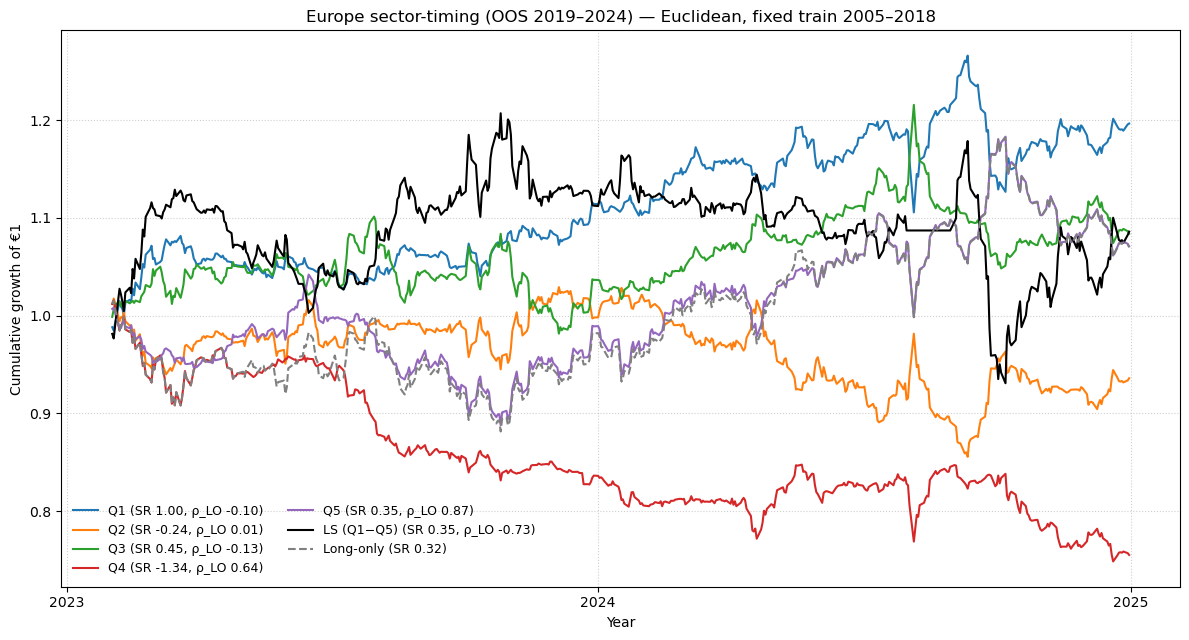

,Ann. Return,Ann. Vol,Ann. Sharpe,Corr vs LO,Max DD,N days
Q1,0.0946,0.0950,0.9992,-0.1038,-0.1101,500.0
Q2,-0.0328,0.1114,-0.2441,0.0099,-0.1688,500.0
Q3,0.0413,0.1022,0.4474,-0.1260,-0.1377,500.0
Q4,-0.1320,0.1015,-1.3432,0.6383,-0.2629,500.0
Q5,0.0351,0.1184,0.3504,0.8712,-0.1479,500.0
LS (Q1−Q5),0.0424,0.1548,0.3455,-0.7299,-0.2289,500.0
Long-only,0.0347,0.1340,0.3218,1.0000,-0.1320,500.0


In [19]:
# =====================================================================
# Euclidean distance on a FIXED training set (2005–2018), OOS 2019–2024
# =====================================================================
def days_in_period(idx_daily: pd.DatetimeIndex, per: pd.Period):
    return idx_daily[idx_daily.to_period('M') == per]

def find_similar_months_euclid_fixed_train(
    df_full: pd.DataFrame,     
    df_train: pd.DataFrame,    
    target: str,
    bottom_pct: float = 1.0
) -> pd.DataFrame:
    T = pd.Period(target, 'M')
    if T not in df_full.index:
        prior = df_full.index[df_full.index < T]
        if len(prior) == 0:
            return pd.DataFrame(columns=['Month','Distance','Rank','IsBottom'])
        T = prior.max()

    candidates = df_train.dropna(how='any')
    if candidates.empty:
        return pd.DataFrame(columns=['Month','Distance','Rank','IsBottom'])

    X   = candidates.values
    x_T = df_full.loc[T].values.reshape(1, -1)
    dist = np.linalg.norm(X - x_T, axis=1)

    out = (pd.DataFrame({'Distance': dist}, index=candidates.index)
             .sort_values('Distance'))
    out['Rank'] = np.arange(1, len(out) + 1)
    n_select = max(int(np.floor(bottom_pct * len(out))), 1)
    out['IsBottom'] = False
    out.iloc[:n_select, out.columns.get_loc('IsBottom')] = True
    return out.reset_index().rename(columns={'index':'Month'})
def _label_col(df):
    if 'Month' in df.columns: return 'Month'
    if 'Dates' in df.columns: return 'Dates'
    return df.columns[0]

def quintile_members_euclid_fixed(target_per: pd.Period):
    full = (find_similar_months_euclid_fixed_train(df_m, df_train, str(target_per), bottom_pct=1.0)
            .sort_values('Distance'))
    if full.empty:
        return {q: np.array([]) for q in range(1,6)}
    lab = _label_col(full)
    n   = len(full); k20 = int(0.20*n)
    if k20 == 0:
        return {1: np.array([]), 2: np.array([]), 3: full[lab].to_numpy(), 4: np.array([]), 5: np.array([])}
    q1  = full.iloc[:k20][lab].to_numpy()
    q5  = full.iloc[-k20:][lab].to_numpy()
    mid = full.iloc[k20:-k20][lab].to_numpy()
    if len(mid) >= 3:
        q2, q3, q4 = np.array_split(mid, 3)
    else:
        q2, q3, q4 = np.array([]), mid, np.array([])
    return {1:q1, 2:q2, 3:q3, 4:q4, 5:q5}

def signal_for_quintile_euclid_fixed(target_per: pd.Period, quintile: int):
    months = quintile_members_euclid_fixed(target_per)[quintile]
    if len(months) == 0:
        return {a: 0 for a in assets}
    idx = pd.PeriodIndex(months, freq='M') + 1  
    signs = {}
    for a in assets:
        r = sec_ret_monthly.loc[sec_ret_monthly.index.intersection(idx), a]
        signs[a] = np.sign(r.mean()) if not r.empty else 0
    return signs
returns_by_q = {q: [] for q in range(1,6)}

for i in range(len(months_bt)-1):
    cur_per, nxt_per = months_bt[i], months_bt[i+1]
    dts = days_in_period(sec_ret_daily.index, nxt_per)
    if len(dts) == 0:
        continue
    Rm = sec_ret_daily.loc[dts, assets]
    for q in range(1,6):
        w = pd.Series(signal_for_quintile_euclid_fixed(cur_per, q), index=assets, dtype=float)
        port_daily = (Rm * w).mean(axis=1)
        returns_by_q[q].extend([{'Date': dt, 'Return': ret} for dt, ret in port_daily.items()])
q_df = {q: pd.DataFrame(lst).set_index('Date').sort_index() for q, lst in returns_by_q.items()}

common_idx = None
for q in range(1,6):
    idx = q_df[q].dropna().index
    common_idx = idx if common_idx is None else common_idx.intersection(idx)
first_trd = common_idx.min()
for q in q_df:
    q_df[q] = q_df[q].loc[first_trd:]

long_only = sec_ret_daily[assets].mean(axis=1).loc[first_trd:].reindex(q_df[1].index).dropna()

def ann_sr(x):
    s = x.std()
    return (x.mean()/s)*np.sqrt(252) if s and s!=0 else np.nan
def ann_ret(x):
    n = len(x)
    return (1 + x).prod()**(252.0/n) - 1 if n > 0 else np.nan
def ann_vol(x):
    return x.std()*np.sqrt(252)
def max_dd(x):
    eq = (1+x).cumprod()
    return (eq/eq.cummax() - 1.0).min()

ports = {
    'Q1': q_df[1]['Return'].dropna(),
    'Q2': q_df[2]['Return'].dropna(),
    'Q3': q_df[3]['Return'].dropna(),
    'Q4': q_df[4]['Return'].dropna(),
    'Q5': q_df[5]['Return'].dropna(),
    'Long-only': long_only.dropna()
}
ls_tmp = pd.concat([ports['Q1'], ports['Q5']], axis=1, keys=['Q1','Q5']).dropna()
ports['LS (Q1−Q5)'] = (ls_tmp['Q1'] - ls_tmp['Q5']).rename('LS (Q1−Q5)')

common_idx_all = None
for s in ports.values():
    common_idx_all = s.index if common_idx_all is None else common_idx_all.intersection(s.index)
ports = {k: v.loc[common_idx_all] for k,v in ports.items()}

rows = {}
lo_aligned = ports['Long-only']
for name, s in ports.items():
    rows[name] = {
        'Ann. Return': ann_ret(s),
        'Ann. Vol':    ann_vol(s),
        'Ann. Sharpe': ann_sr(s),
        'Corr vs LO':  s.corr(lo_aligned),
        'Max DD':      max_dd(s),
        'N days':      len(s),
    }
summary_df = pd.DataFrame(rows).T.loc[['Q1','Q2','Q3','Q4','Q5','LS (Q1−Q5)','Long-only']]

cum = lambda x: (1+x).cumprod()
plt.figure(figsize=(12, 6.5))
colors = {1:"tab:blue", 2:"tab:orange", 3:"tab:green", 4:"tab:red", 5:"tab:purple"}

for q in [1,2,3,4,5]:
    s  = ports[f'Q{q}']
    sr = summary_df.loc[f'Q{q}', 'Ann. Sharpe']
    rho= summary_df.loc[f'Q{q}', 'Corr vs LO']
    plt.plot(s.index, cum(s), color=colors[q], label=f"Q{q} (SR {sr:.2f}, \u03C1_LO {rho:.2f})")

sr_ls  = summary_df.loc['LS (Q1−Q5)', 'Ann. Sharpe']
rho_ls = summary_df.loc['LS (Q1−Q5)', 'Corr vs LO']
plt.plot(ports['LS (Q1−Q5)'].index, cum(ports['LS (Q1−Q5)']), color='black',
         label=f"LS (Q1−Q5) (SR {sr_ls:.2f}, \u03C1_LO {rho_ls:.2f})")

sr_lo = summary_df.loc['Long-only', 'Ann. Sharpe']
plt.plot(ports['Long-only'].index, cum(ports['Long-only']), color='gray', ls='--',
         label=f"Long-only (SR {sr_lo:.2f})")

plt.title("Europe sector-timing (OOS 2019–2024) — Euclidean, fixed train 2005–2018")
plt.xlabel("Year"); plt.ylabel("Cumulative growth of €1")
plt.grid(ls=":", alpha=.6)
ax = plt.gca()
ax.legend(frameon=False, fontsize=9, ncols=2)
ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()

summary_df.round(4)



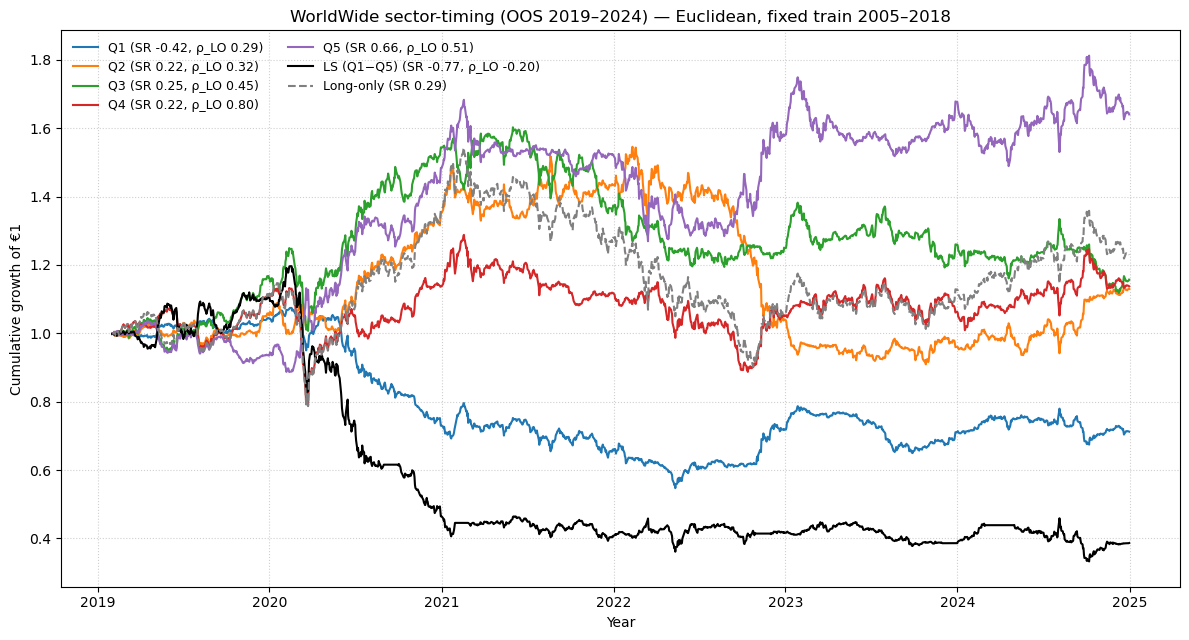

,Ann. Return,Ann. Vol,Ann. Sharpe,Corr vs LO,Max DD,N days
Q1,-0.0539,0.1153,-0.4230,0.2923,-0.4908,1543.0
Q2,0.0202,0.1290,0.2197,0.3194,-0.4118,1543.0
Q3,0.0241,0.1238,0.2544,0.4485,-0.3024,1543.0
Q4,0.0213,0.1427,0.2191,0.8041,-0.3113,1543.0
Q5,0.0842,0.1359,0.6628,0.5130,-0.2459,1543.0
LS (Q1−Q5),-0.1438,0.1808,-0.7681,-0.1992,-0.7220,1543.0
Long-only,0.0343,0.1660,0.2865,1.0000,-0.4153,1543.0


In [5]:

import warnings
warnings.filterwarnings("ignore", message=".*DataFrame.swapaxes.*")

def days_in_period(idx_daily: pd.DatetimeIndex, per: pd.Period):
    return idx_daily[idx_daily.to_period('M') == per]
def _distance_weights(d: pd.Series,
                      kernel: str = "inv",
                      h: float | None = None,
                      bw_quantile: float = 0.9,
                      eps: float = 1e-12) -> pd.Series:
   
    d = pd.to_numeric(d, errors="coerce").astype(float)
    if h is None and kernel in ("gaussian", "tricube"):
        finite = d[np.isfinite(d)]
        if len(finite) == 0:
            h = 1.0
        else:
            h = np.quantile(finite, bw_quantile)
            h = max(h, eps)

    if kernel == "inv":
        w = 1.0 / (d.values + eps)

    elif kernel == "gaussian":
        u = d.values / h
        w = np.exp(-0.5 * u * u)

    elif kernel == "tricube":
        u = np.clip(d.values / h, 0, 1)
        w = (1 - u**3)**3

    elif kernel == "rank":
        ranks = np.arange(1, len(d) + 1, dtype=float)
        w = 1.0 / ranks

    else:
        raise ValueError("kernel must be one of {'inv','gaussian','tricube','rank'}")

    w = np.clip(w, 0, np.inf)
    s = w.sum()
    if not np.isfinite(s) or s <= 0:
        w = np.ones_like(w) / max(len(w), 1)
    else:
        w = w / s
    return pd.Series(w, index=d.index)

def find_similar_months_euclid_fixed_train(
    df_full: pd.DataFrame,     
    df_train: pd.DataFrame,    
    target: str,
    bottom_pct: float = 1.0
) -> pd.DataFrame:
    T = pd.Period(target, 'M')
    if T not in df_full.index:
        prior = df_full.index[df_full.index < T]
        if len(prior) == 0:
            return pd.DataFrame(columns=['Month','Distance','Rank','IsBottom'])
        T = prior.max()

    candidates = df_train.dropna(how='any')
    if candidates.empty:
        return pd.DataFrame(columns=['Month','Distance','Rank','IsBottom'])

    X   = candidates.values
    x_T = df_full.loc[T].values.reshape(1, -1)
    dist = np.linalg.norm(X - x_T, axis=1)

    out = (pd.DataFrame({'Distance': dist}, index=candidates.index)
             .sort_values('Distance'))
    out['Rank'] = np.arange(1, len(out) + 1)
    n_select = max(int(np.floor(bottom_pct * len(out))), 1)
    out['IsBottom'] = False
    out.iloc[:n_select, out.columns.get_loc('IsBottom')] = True
    return out.reset_index().rename(columns={'index':'Month'})
def _label_col(df):
    if 'Month' in df.columns: return 'Month'
    if 'Dates' in df.columns: return 'Dates'
    return df.columns[0]

def quintile_members_euclid_fixed(target_per: pd.Period):
    full = (find_similar_months_euclid_fixed_train(df_m, df_train, str(target_per), bottom_pct=1.0)
            .sort_values('Distance'))
    if full.empty:
        return {q: np.array([]) for q in range(1,6)}
    lab = _label_col(full)
    n   = len(full); k20 = int(0.20*n)
    if k20 == 0:
        return {1: np.array([]), 2: np.array([]), 3: full[lab].to_numpy(), 4: np.array([]), 5: np.array([])}
    q1  = full.iloc[:k20][lab].to_numpy()
    q5  = full.iloc[-k20:][lab].to_numpy()
    mid = full.iloc[k20:-k20][lab].to_numpy()
    if len(mid) >= 3:
        q2, q3, q4 = np.array_split(mid, 3)
    else:
        q2, q3, q4 = np.array([]), mid, np.array([])
    return {1:q1, 2:q2, 3:q3, 4:q4, 5:q5}
returns_by_q = {q: [] for q in range(1,6)}


def signal_for_quintile_euclid_fixed_weighted(
    target_per: pd.Period,
    quintile: int,
    kernel: str = "inv",         
    h: float | None = None,      
    bw_quantile: float = 0.9,    
    exposure_mode: str = "sign"  
):

    full = (find_similar_months_euclid_fixed_train(df_m, df_train, str(target_per), bottom_pct=1.0)
            .sort_values("Distance"))
    if full.empty:
        return {a: 0 for a in assets}

    lab = _label_col(full)
    n   = len(full)
    k20 = int(0.20 * n)
    if k20 == 0:
        return {a: 0 for a in assets}

    if quintile == 1:
        slice_df = full.iloc[:k20]
    elif quintile == 5:
        slice_df = full.iloc[-k20:]
    else:
        mid = full.iloc[k20:-k20]
        chunks = np.array_split(mid, 3) if len(mid) >= 3 else [mid, mid.iloc[0:0], mid.iloc[0:0]]
        slice_df = chunks[quintile - 2] 

    if slice_df.empty:
        return {a: 0 for a in assets}

    slice_df = slice_df.copy()
    if not isinstance(slice_df[lab].iloc[0], pd.Period):
        slice_df[lab] = pd.PeriodIndex(pd.to_datetime(slice_df[lab]), freq="M")

    dist_series = (slice_df
               .set_index(lab)["Distance"]         
               .astype(float))
    w_sim = _distance_weights(dist_series, kernel=kernel, h=h, bw_quantile=bw_quantile)
    w_next = pd.Series(w_sim.values, index=(dist_series.index + 1)) 

    out = {}
    for a in assets:
        r = sec_ret_monthly[a]
        idx = r.index.intersection(w_next.index)
        if len(idx) == 0:
            out[a] = 0
            continue
        r_use = r.loc[idx].astype(float)
        w_use = w_next.loc[idx].astype(float)
        mu_w  = np.average(r_use.values, weights=w_use.values)

        if exposure_mode == "sign":
            out[a] = float(np.sign(mu_w)) if np.isfinite(mu_w) else 0.0
        else:
            out[a] = float(np.clip(mu_w / (np.abs(r_use).median() + 1e-12), -1, 1))
    return out
SIGNAL_FN = lambda cur_per, q: signal_for_quintile_euclid_fixed_weighted(
    cur_per, q, kernel="inv"    
)

for i in range(len(months_bt)-1):
    cur_per, nxt_per = months_bt[i], months_bt[i+1]
    dts = days_in_period(sec_ret_daily.index, nxt_per)
    if len(dts) == 0:
        continue
    Rm = sec_ret_daily.loc[dts, assets]
    for q in range(1,6):
        w = pd.Series(SIGNAL_FN(cur_per, q), index=assets, dtype=float)
        port_daily = (Rm * w).mean(axis=1)
        returns_by_q[q].extend([{'Date': dt, 'Return': ret} for dt, ret in port_daily.items()])
q_df = {q: pd.DataFrame(lst).set_index('Date').sort_index() for q, lst in returns_by_q.items()}

common_idx = None
for q in range(1,6):
    idx = q_df[q].dropna().index
    common_idx = idx if common_idx is None else common_idx.intersection(idx)
first_trd = common_idx.min()
for q in q_df:
    q_df[q] = q_df[q].loc[first_trd:]

long_only = sec_ret_daily[assets].mean(axis=1).loc[first_trd:].reindex(q_df[1].index).dropna()

def ann_sr(x):
    s = x.std()
    return (x.mean()/s)*np.sqrt(252) if s and s!=0 else np.nan
def ann_ret(x):
    n = len(x)
    return (1 + x).prod()**(252.0/n) - 1 if n > 0 else np.nan
def ann_vol(x):
    return x.std()*np.sqrt(252)
def max_dd(x):
    eq = (1+x).cumprod()
    return (eq/eq.cummax() - 1.0).min()

ports = {
    'Q1': q_df[1]['Return'].dropna(),
    'Q2': q_df[2]['Return'].dropna(),
    'Q3': q_df[3]['Return'].dropna(),
    'Q4': q_df[4]['Return'].dropna(),
    'Q5': q_df[5]['Return'].dropna(),
    'Long-only': long_only.dropna()
}
ls_tmp = pd.concat([ports['Q1'], ports['Q5']], axis=1, keys=['Q1','Q5']).dropna()
ports['LS (Q1−Q5)'] = (ls_tmp['Q1'] - ls_tmp['Q5']).rename('LS (Q1−Q5)')

common_idx_all = None
for s in ports.values():
    common_idx_all = s.index if common_idx_all is None else common_idx_all.intersection(s.index)
ports = {k: v.loc[common_idx_all] for k,v in ports.items()}

rows = {}
lo_aligned = ports['Long-only']
for name, s in ports.items():
    rows[name] = {
        'Ann. Return': ann_ret(s),
        'Ann. Vol':    ann_vol(s),
        'Ann. Sharpe': ann_sr(s),
        'Corr vs LO':  s.corr(lo_aligned),
        'Max DD':      max_dd(s),
        'N days':      len(s),
    }
summary_df = pd.DataFrame(rows).T.loc[['Q1','Q2','Q3','Q4','Q5','LS (Q1−Q5)','Long-only']]

cum = lambda x: (1+x).cumprod()
plt.figure(figsize=(12, 6.5))
colors = {1:"tab:blue", 2:"tab:orange", 3:"tab:green", 4:"tab:red", 5:"tab:purple"}

for q in [1,2,3,4,5]:
    s  = ports[f'Q{q}']
    sr = summary_df.loc[f'Q{q}', 'Ann. Sharpe']
    rho= summary_df.loc[f'Q{q}', 'Corr vs LO']
    plt.plot(s.index, cum(s), color=colors[q], label=f"Q{q} (SR {sr:.2f}, \u03C1_LO {rho:.2f})")

sr_ls  = summary_df.loc['LS (Q1−Q5)', 'Ann. Sharpe']
rho_ls = summary_df.loc['LS (Q1−Q5)', 'Corr vs LO']
plt.plot(ports['LS (Q1−Q5)'].index, cum(ports['LS (Q1−Q5)']), color='black',
         label=f"LS (Q1−Q5) (SR {sr_ls:.2f}, \u03C1_LO {rho_ls:.2f})")

sr_lo = summary_df.loc['Long-only', 'Ann. Sharpe']
plt.plot(ports['Long-only'].index, cum(ports['Long-only']), color='gray', ls='--',
         label=f"Long-only (SR {sr_lo:.2f})")

plt.title("WorldWide sector-timing (OOS 2019–2024) — Euclidean, fixed train 2005–2018")
plt.xlabel("Year"); plt.ylabel("Cumulative growth of €1")
plt.grid(ls=":", alpha=.6)
ax = plt.gca()
ax.legend(frameon=False, fontsize=9, ncols=2)
ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()

# Show metrics
summary_df.round(4)